### Specify Inputs

In [357]:
# This is the experiment code we want to look at.
search = "QSC023|QSC024|QSC025" #for build campaign/push cells
#search = "QSC024R|QSC025"  #new flow during push
#search = "QSC024[A-N]"     #old flow during push


GroupBy = 'Experiment'  #Group cells by Experiment code (MLB006, MLD023, FCD00, etc) in screen and cycle plots
GroupBy = 'WorkWeek'  #Group cells by work week built in screen and cycle plots
#GroupBy = 'Cathode' #Group cells by cathode batch
#GroupBy = 'Batch'   #Group cells by batches (MLB006AA, MLB006AB, MLB00AC, etc) in screen and cycle plots
#GroupBy = 'BuildDate' #Group cells by build date

CellsToExclude = ['MLD023AB-PS00-01', 'MLD023AB-PS00-02', 'MLD023AB-PS00-05', 'QSC022AG-PS00-03', 'MLB006AP-PS00-04'] #Cells that should not be included in BOTH yield and reliability cycling analyses and plots

CellsThatPassedScreen = ['MLB006AH-PS00-03', 'QSC025NP-PS00-02', 
                         'MLB007AB-PS00-01', 'MLB007AB-PS00-02',
                         'MLD007AW-PS00-02', 'MLD007AX-PS00-01', 'MLD007AX-PS00-02', 'MLD007BA-PS00-01', 'MLD007BA-PS00-02', 'MLD007BA-PS00-04', 
                         'MLD012AP-PS00-01', 'MLD012AP-PS00-02',
                         'MLD023AC-PS00-02','MLD023AD-PS00-01','MLD023AD-PS00-02','MLD023AD-PS00-03', 'MLD023AD-PS00-04', 'MLD023AD-PS00-05'] # List of cells that did not fail screen despite datahub saying it did

CellsThatFailedScreen = ['QSC025NQ-PS00-06','MLD023AF-PS00-03', 'MLD023AB-PS00-03', 'MLB006AU-PS00-03'] # List of cells that should have failed screen despite datahub saying it didn't (i.e. "soft-shorted" during screening)


builtby = "7/01/2024" #search for cells built on or after this date


### Import Functions and Modules

In [358]:
#Import libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.graph_objects as go
from qsdc.client import Client
from datetime import datetime
import warnings
from scipy.stats import mode


pio.templates.default = "plotly_white"
clrs = plotly.colors.DEFAULT_PLOTLY_COLORS
qs_client = Client()

#Remove warning messages
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Convert builtby to datetime
builtby_date = pd.to_datetime(builtby, format="%m/%d/%Y")

### Pull from Datahub


In [359]:
#Pull multilayer screen data
MLScreenEach = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-SCREEN-CYCLE') ##electrical test data of unit cells for each cycle
MLScreenSummary = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-SCREEN') ##electrical test data of unit cells that sumamrizes each screen test

#Pull multilayer track cycle TC data
MLTrackCycleEach = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-TRACK-CYCLE-REL-CYCLE')
MLTrackCycleSummary = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-TRACK-CYCLE-REL')
#Pull multilayer 1C SLCT cycle data
MLslctCycleSummary = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-SLCT')
MLslctCycleEach = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-SLCT-CYCLE')
#Pull multilayer IAA cycle data
MLIAACycleSummary = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-IAA')
MLIAACycleEach = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-IAA-CYCLE')

#Pull geneology/multilayer info of unit cells
dmlg = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-PRODUCTION') ##multilayer info (ML_id)
dmlg = dmlg.drop_duplicates(subset='US_id')

#Pull cell metrology data from datahub, both standard/auto metrology and manual review
dfctq = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UC-CTQ') ## standard metro
dfc = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UNIT-CELL-TEST-CYCLE') ##electrical test data of unit cells

#Pull cathode data
cathode_mass = qs_client.data_hub.get_dataset("MFG-50L-CATHODE-CTQ")
CathodeMetrics = cathode_mass

#Pull Unit Cell ancestry
danc = qs_client.data_hub.get_dataset("MFG-UNIT-CELL-ANCESTRY")

/Users/mpg01/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qsdc/datahub/datahub.py:80: DtypeWarning:

Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/mpg01/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qsdc/datahub/datahub.py:80: DtypeWarning:

Columns (15,39,40) have mixed types. Specify dtype option on import or set low_memory=False.



### Create Master Spreadsheets

In [361]:
##Create a Master Spreadsheet for Screening data
# Grab electrical metrics by consolidating individual cycles in screen
def last_non_missing(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else None
def minimum_non_missing(series):
    return series.dropna().min() if not series.dropna().empty else None
# Group by cell id and consolidate
dfc_consolidated = (
    MLScreenEach.groupby('MLT_id', as_index=False)
    .agg({
        'AMSDcCapacity': last_non_missing,
        'DischargeCapacity': last_non_missing,
        'dvdt':minimum_non_missing, 
        'MedDcASR': last_non_missing
    })
)
dfc_consolidated = dfc_consolidated.rename(columns={
    'AMSDcCapacity': 'CellSpecificDischargeCapacity',
    'DischargeCapacity': 'CellCo3DischargeCapcity',
    'dvdt': 'Celldvdt',
    'MedDcASR': 'Cell1CDischargeASR'
})
MLScreenSummary = MLScreenSummary.merge(
    dfc_consolidated,
    left_on='MLT_id',
    right_on='MLT_id',
    how='inner'  # Use 'inner' to keep only matching rows; adjust to 'left' or 'outer' as needed
)

#Filter by what we are searching for
filtered_MLScreenSummary = MLScreenSummary[MLScreenSummary['MLT_id'].str.contains(search, regex=True)]
filtered_MLScreenEach = MLScreenEach[MLScreenEach['MLT_id'].str.contains(search, regex=True)]
#Overwrite screen yield for cells that didn't really short
columns_to_overwrite = ['ML_screen_finished', 'ML_screen_yield', 'stage1_yield', 'stage2_yield', 'stage3_yield', 'stage4_yield', 'stage5_yield', 'stage6_yield', 'stage7_yield'] # Specify columns to overwrite
filtered_MLScreenSummary.loc[filtered_MLScreenSummary['MLT_id'].isin(CellsThatPassedScreen), columns_to_overwrite] = 1 # Overwrite the specified columns with 1 for matching rows
filtered_MLScreenSummary.loc[filtered_MLScreenSummary['MLT_id'].isin(CellsThatPassedScreen), ['CycleFailure', 'AnyFailure']] = False # Overwrite the specified columns with 1 for matching rows
# Suppose CellsThatFailedScreen is a list of strings
filtered_MLScreenSummary.loc[filtered_MLScreenSummary['MLT_id'].isin(CellsThatFailedScreen), columns_to_overwrite] = 0 # Overwrite the specified columns with 1 for matching rows
filtered_MLScreenSummary.loc[filtered_MLScreenSummary['MLT_id'].isin(CellsThatFailedScreen), ['CycleFailure', 'AnyFailure']] = True # Overwrite the specified columns with 1 for matching rows

columns_to_overwrite2 = ['AnyFailure', 'CycleFailure'] # Specify columns to overwrite
filtered_MLScreenSummary.loc[filtered_MLScreenSummary['MLT_id'].isin(CellsThatPassedScreen), columns_to_overwrite2] = False

# Exclude cells
MLScreenMaster = filtered_MLScreenSummary[~filtered_MLScreenSummary['MLT_id'].isin(CellsToExclude)] 

# Add additional columns that are typically used for grouping
MLScreenMaster['Experiment']= MLScreenMaster['MLT_id'].str[:6]  #Specify experiment
MLScreenMaster['Cathode']= MLScreenMaster['MLT_id'].str[:7] #Specify Cathode batch
MLScreenMaster['Batch']= MLScreenMaster['MLT_id'].str[:8]  #Specify batch
MLScreenMaster['WorkWeek']= MLScreenMaster['TestCycleStart_week_first']  #Specify work week
MLScreenMaster['BuildDate']= MLScreenMaster['ML_start_datetime'].str[:10]  #Specify build date
MLScreenMaster['BuildDate'] = MLScreenMaster['BuildDate'].astype(str)

# Group screen yield by:
MLScreenMaster['Group']= MLScreenMaster[GroupBy]  #Assign group in new column



In [362]:
##Create a Master Spreadsheets for Cycling Data

#Filter by what we are searching for
MLTrackCycleSummary = MLTrackCycleSummary[MLTrackCycleSummary['sample_id'].str.contains(search, regex=True)]
MLTrackCycleEach = MLTrackCycleEach[MLTrackCycleEach['sample_id'].str.contains(search, regex=True)]
MLslctCycleSummary = MLslctCycleSummary[MLslctCycleSummary['MLT_id'].str.contains(search, regex=True)]
MLslctCycleEach = MLslctCycleEach[MLslctCycleEach['MLT_id'].str.contains(search, regex=True)]
MLIAACycleSummary = MLIAACycleSummary[MLIAACycleSummary['MLT_id'].str.contains(search, regex=True)]
MLIAACycleEach = MLIAACycleEach[MLIAACycleEach['MLT_id'].str.contains(search, regex=True)]


# Exclude cells
MLTrackCycleSummary = MLTrackCycleSummary[~MLTrackCycleSummary['sample_id'].isin(CellsToExclude)] 
MLTrackCycleEach = MLTrackCycleEach[~MLTrackCycleEach['sample_id'].isin(CellsToExclude)] 
MLslctCycleSummary = MLslctCycleSummary[~MLslctCycleSummary['MLT_id'].isin(CellsToExclude)] 
MLslctCycleEach = MLslctCycleEach[~MLslctCycleEach['MLT_id'].isin(CellsToExclude)] 
MLIAACycleSummary = MLIAACycleSummary[~MLIAACycleSummary['MLT_id'].isin(CellsToExclude)] 
MLIAACycleEach = MLIAACycleEach[~MLIAACycleEach['MLT_id'].isin(CellsToExclude)] 



non_empty_failures = [cell for cell in CellsThatFailedScreen if cell.strip()]
if non_empty_failures:
    pattern = '|'.join(non_empty_failures)
    MLTrackCycleSummary = MLTrackCycleSummary[~MLTrackCycleSummary['sample_id'].str.contains(pattern)]
    MLTrackCycleEach = MLTrackCycleEach[~MLTrackCycleEach['sample_id'].str.contains(pattern)]
    MLslctCycleSummary = MLslctCycleSummary[~MLslctCycleSummary['MLT_id'].str.contains(pattern)]
    MLslctCycleEach = MLslctCycleEach[~MLslctCycleEach['MLT_id'].str.contains(pattern)]
    MLIAACycleSummary = MLIAACycleSummary[~MLIAACycleSummary['MLT_id'].str.contains(pattern)]
    MLIAACycleEach = MLIAACycleEach[~MLIAACycleEach['MLT_id'].str.contains(pattern)]


MLTrackCycleEach.loc[MLTrackCycleEach['MiscTestAnomaly'] == 1, ['dvdt_failure', 'min_track_cycle_voltage_failure', 'CapacityChargeFraction_failure'] ] = [0, 0, 0]

# Add additional columns that are typically used for grouping
MLTrackCycleEach['Experiment']= MLTrackCycleEach['sample_id'].str[:6]  #Specify experiment
MLTrackCycleEach['Cathode']= MLTrackCycleEach['sample_id'].str[:7]  #Specify cathode 
MLTrackCycleEach['Batch']= MLTrackCycleEach['sample_id'].str[:8]  #Specify batch
MLTrackCycleEach['WorkWeek']= MLTrackCycleEach['TestCycleStart_week_first']  #Specify work week
MLTrackCycleEach = MLTrackCycleEach.merge(MLScreenMaster[['ML_id', 'BuildDate']],left_on='sample_id',     right_on='ML_id',     how='left')


MLslctCycleEach['Experiment']= MLslctCycleEach['MLT_id'].str[:6]  #Specify experiment
MLslctCycleEach['Cathode']= MLslctCycleEach['MLT_id'].str[:7]  #Specify cathode
MLslctCycleEach['Batch']= MLslctCycleEach['MLT_id'].str[:8]  #Specify batch
MLslctCycleEach['WorkWeek']= MLslctCycleEach['TestCycleStart_week_first']  #Specify work week
MLslctCycleEach = MLslctCycleEach.merge(MLScreenMaster[['ML_id', 'BuildDate']],left_on='ML_id',     right_on='ML_id',     how='left')

MLIAACycleEach['Experiment']= MLIAACycleEach['MLT_id'].str[:6]  #Specify experiment
MLIAACycleEach['Cathode']= MLIAACycleEach['MLT_id'].str[:7]  #Specify cathode
MLIAACycleEach['Batch']= MLIAACycleEach['MLT_id'].str[:8]  #Specify batch
MLIAACycleEach['WorkWeek']= MLIAACycleEach['TestCycleStart_week_first']  #Specify work week
MLIAACycleEach = MLIAACycleEach.merge(MLScreenMaster[['ML_id', 'BuildDate']],left_on='ML_id',     right_on='ML_id',     how='left')


MLTrackCycleSummary['Experiment']= MLTrackCycleSummary['sample_id'].str[:6]  #Specify experiment
MLTrackCycleSummary['Cathode']= MLTrackCycleSummary['sample_id'].str[:7]  #Specify cathode
MLTrackCycleSummary['Batch']= MLTrackCycleSummary['sample_id'].str[:8]  #Specify batch
MLTrackCycleSummary['WorkWeek']= MLTrackCycleSummary['TestCycleStart_week_first']  #Specify work week
MLTrackCycleSummary = MLTrackCycleSummary.merge(MLScreenMaster[['ML_id', 'BuildDate']], left_on='sample_id', right_on='ML_id', how='left')


MLslctCycleSummary['Experiment']= MLslctCycleSummary['MLT_id'].str[:6]  #Specify experiment
MLslctCycleSummary['Cathode']= MLslctCycleSummary['MLT_id'].str[:7]  #Specify cathode
MLslctCycleSummary['Batch']= MLslctCycleSummary['MLT_id'].str[:8]  #Specify experiment
MLslctCycleSummary['WorkWeek']= MLslctCycleSummary['TestCycleStart_week_first']  #Specify work week
MLslctCycleSummary = MLslctCycleSummary.merge(MLScreenMaster[['ML_id', 'BuildDate']], left_on='ML_id', right_on='ML_id', how='left')

MLIAACycleSummary['Experiment']= MLIAACycleSummary['MLT_id'].str[:6]  #Specify experiment
MLIAACycleSummary['Cathode']= MLIAACycleSummary['MLT_id'].str[:7]  #Specify cathode
MLIAACycleSummary['Batch']= MLIAACycleSummary['MLT_id'].str[:8]  #Specify experiment
MLIAACycleSummary['WorkWeek']= MLIAACycleSummary['TestCycleStart_week_first']  #Specify work week
MLIAACycleSummary = MLIAACycleSummary.merge(MLScreenMaster[['ML_id', 'BuildDate']], left_on='ML_id', right_on='ML_id', how='left')


# Group track cycles by:
MLTrackCycleEach['Group']= MLTrackCycleEach[GroupBy]  #Group in new column 
MLslctCycleEach['Group']= MLslctCycleEach[GroupBy]  #Group in new column 
MLIAACycleEach['Group']= MLIAACycleEach[GroupBy]  #Group in new column 

MLTrackCycleSummary['Group']= MLTrackCycleSummary[GroupBy]  #Group in new column
MLslctCycleSummary['Group']= MLslctCycleSummary[GroupBy]  #Group in new column
MLIAACycleSummary['Group']= MLIAACycleSummary[GroupBy]  #Group in new column


In [363]:
##Tier Each ML Pouch
#Pull geneology/multilayer info
dmlg = dmlg.drop_duplicates(subset='US_id')
CellsInML = MLScreenMaster.merge(dmlg, left_on='MLT_id', right_on='ML_id', how='left')
CellsInML = CellsInML[['MLT_id', 'US_id']].rename(columns={'US_id': 'Cell ID'})

dfctq_filtered = dfctq[dfctq['US_id'].isin(CellsInML['Cell ID'])]

dfctq_updated = dfctq_filtered[dfctq_filtered['unit_cell_test_yield'] == 1] #keep cells that yielded



#Update Final Tier of Cells
conditions = [
    dfctq_updated['disposition'] == 'Tier 1',
    dfctq_updated['disposition'] == 'Tier 2',
    dfctq_updated['disposition'] == 'Fail',
    dfctq_updated['disposition'] == 'Scrap',
    dfctq_updated['disposition'] == 'Missing Data',
]
choices = ['1', '2', '3','Scrapped', 'TBD']
dfctq_updated['Tier'] = np.select(conditions, choices)



# Merge dfctq_updated['US_id', 'Tier'] with CellsInML based on 'US_id'
CellsInML = CellsInML.merge(dfctq_updated[['US_id', 'Tier', 'center_normalized_0_5mm_eroded_rect_outside_median_us','median_contour_catholyte_pct_us']], 
                            left_on='Cell ID', 
                            right_on='US_id', 
                            how='left')


# Assign the 'Tier' column to 'Cell Tier' and drop the extra 'US_id' column
CellsInML['Cell Tier'] = CellsInML['Tier']
CellsInML = CellsInML.drop(columns=['Tier', 'US_id'])

# Group by "samplename" and find the max "Cell Tier" for each
CellsInML['Cell Tier'] = pd.to_numeric(CellsInML['Cell Tier'], errors='coerce')
FinalMLTier = CellsInML.groupby('MLT_id', as_index=False)['Cell Tier'].max()
FinalMLThickness = CellsInML.groupby('MLT_id', as_index=False)['center_normalized_0_5mm_eroded_rect_outside_median_us'].max()

# Rename columns as required
FinalMLTier.columns = ['Multilayer', 'ML Tier']
# Convert "ML Tier" to integer and format as "Tier {max Cell Tier}"
# Conditionally update 'ML Tier'
FinalMLTier['ML Tier'] = np.where(
    FinalMLTier['ML Tier'].isna(), 
    np.nan,  # Keep NaN if it was originally NaN
    "Tier " + FinalMLTier['ML Tier'].fillna(0).astype(int).astype(str)
)

# Merge df_master with FinalMLTier on "samplename" and "Multilayer"
MLScreenMaster= MLScreenMaster.merge(FinalMLTier, left_on='MLT_id', right_on='Multilayer', how='left')
# Merge df_master with FinalMLThickness on "MLT_id" and "Multilayer"
MLScreenMaster = MLScreenMaster.merge(FinalMLThickness, left_on='MLT_id', right_on='MLT_id', how='left')

# Update "cell_tier_group" with the values from "ML Tier"
MLScreenMaster['cell_tier_group'] = MLScreenMaster['ML Tier']

# Drop the extra "Multilayer" and "ML Tier" columns
MLScreenMaster = MLScreenMaster.drop(columns=['Multilayer', 'ML Tier'])

### Plot Multilayer Production Yield

In [364]:
#Create dataframe of all cells produced with columns of interest
CellsProduced = dmlg[['ML_id', 'ML_expt', 'ML_process_flow', 'ML_process_name', 'ML_created_date', 'ML_created_week', 'ML_status']].drop_duplicates()
CellsProduced['Cathode']= CellsProduced['ML_id'].str[:7] #Specify Cathode batch
CellsProduced = CellsProduced[CellsProduced['ML_id'].str.contains(search, regex=True)]
# CellsProduced = CellsProduced[CellsProduced['ML_status'] == 'Produced']

CellsProduced = CellsProduced.rename(columns={'ML_expt': 'Experiment','ML_process_flow': 'Batch', 'ML_created_date': 'BuildDate', 'ML_created_week': 'WorkWeek'})# Consolidate column renaming in a single step

CellsProduced['Group']= CellsProduced[GroupBy]  #Assign group in new column

#Create new column that indicates if cell was placed on screen
CellsProduced['Screened'] = np.where(
    CellsProduced['ML_id'].isin(MLScreenMaster['ML_id']),
    1,
    0  # Optional: Set to 0 if you want a default value
)

##Plot Production yield
# Group by 'Group' and count total and screened cells
grouped = CellsProduced.groupby('Group').agg(
    Total_Cells=('Screened', 'count'),
    Screened_Cells=('Screened', 'sum')
).reset_index()

# Normalize 'Screened' yield to percentage
grouped['Screened_Yield'] = (grouped['Screened_Cells'] / grouped['Total_Cells']) * 100

# Define the plot data
bar_labels = ['Total Cells Produced', 'Cells Put on Screen (Production Yield)']
bar_data = []

# Convert to structured format
for _, row in grouped.iterrows():
    bar_data.append([100, row['Screened_Yield']])  # 100% represents total cells
group_labels = grouped['Group'].tolist()

# Convert into DataFrame for Plotly
plot_data = pd.DataFrame(bar_data, columns=bar_labels, index=group_labels).reset_index()
plot_data.rename(columns={'index': 'Group'}, inplace=True)

# Define colors
colors = [px.colors.qualitative.Plotly[2], px.colors.qualitative.Plotly[5]]

# Create interactive bar chart
fig = px.bar(
    plot_data,
    x="Group",
    y=bar_labels,
    title="ML Production Yield",
    labels={'value': 'Percentage (%)'},
    barmode='group',
    color_discrete_sequence=colors
)

# Update layout for better visualization)

fig.update_layout(
    title=dict(font=dict(size=24)),
    xaxis=dict(
        title=dict(font=dict(size=18)), 
        tickfont=dict(size=16),
        tickangle=0  # Set labels at 0-degree angle (horizontal)
    ),
    yaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),
    legend=dict(font=dict(size=16)),
)


# Add text labels for total samples
plot_data["Total Samples"] = plot_data['Group'].apply(lambda g: len(CellsProduced[CellsProduced['Group'] == g]))
total_samples_text = [f"<b>N={n}</b>" for n in plot_data["Total Samples"]]
screened_yield_text = [f"<b>{y:.1f}%</b>" for y in grouped["Screened_Yield"]]

# Assign text to bars
if len(fig.data) > 0:
    fig.data[0].text = total_samples_text  # First bar (Total Cells)
    fig.data[-1].text = screened_yield_text  # Last bar (Screened Yield)

# Display text inside bars and set text angle to 0 degrees
fig.update_traces(
    textposition="outside",  # Move labels outside the bars for visibility
    textangle=0,  # Force labels to always be horizontal
    textfont_size=18
)


# Display text inside bars
fig.update_traces(textposition="inside", textfont_size=18)

# Add grey dotted line at 80% yield
fig.add_shape(
    type="line",
    x0=-0.5,
    x1=plot_data.shape[0] - 0.5,
    y0=80,
    y1=80,
    line=dict(color="grey", width=2, dash="dot"),
)

# Show the plot
fig.show(renderer="browser")



### Plot Multilayer Screen Yield

In [182]:
#Plot 6L Standard Screen Yield
finishedScreen = MLScreenMaster[MLScreenMaster["ML_screen_finished"] == 1]  # Ensure it's an integer, not a string
finishedScreen6L = finishedScreen[finishedScreen['TestVersion'].str.contains('Y6', na=False)]



samples_to_plot = search
grouping_to_plot = "Group"


finishedScreen6L = finishedScreen6L[finishedScreen6L['ML_id'].str.contains(samples_to_plot)]
grouped = finishedScreen6L.groupby(grouping_to_plot)


# Calculate normalized bar values for each group
bar_data = []
group_labels = []
for group, df_group in grouped:
    total_rows = len(df_group)
    stage1_count = df_group['stage1_yield'].sum()
    stage2_count = df_group['stage2_yield'].sum()
    stage3_count = df_group['stage3_yield'].sum()
    stage4_count = df_group['stage4_yield'].sum()
    stage5_count = (df_group['CycleFailure'] == False).sum()
    
    # Normalize the values to percentages
    bar_values_percentage = [
        (total_rows / total_rows) * 100,                         
        (stage1_count / total_rows) * 100,        
        (stage2_count / total_rows) * 100, 
        (stage3_count / total_rows) * 100, 
        (stage4_count / total_rows) * 100,
        (stage5_count / total_rows) * 100                         
    ]
    
    bar_data.append(bar_values_percentage)
    group_labels.append(group)

# Define bar labels
bar_labels = ['Cells Built', 'Initial 1C Yield', 'Fast-Charge Yield', 'Final 1C Yield', 'C/3 Cycle Yield', 'C/3 Charge Yield']
# Create a new DataFrame for Plotly Express
plot_data = pd.DataFrame(bar_data, columns=bar_labels, index=group_labels)
# Reset index for x-axis labeling
plot_data.reset_index(inplace=True)
plot_data.rename(columns={'index': grouping_to_plot}, inplace=True)

# Define colors for each bar
colors = [
    px.colors.qualitative.Plotly[2], 
    px.colors.qualitative.Plotly[5], 
    px.colors.qualitative.Plotly[3],  
    px.colors.qualitative.Plotly[6],  
    px.colors.qualitative.Plotly[1],  
    px.colors.qualitative.Plotly[4]
]
# Create the interactive bar chart with Plotly Express, specifying width, height, and custom font sizes
fig = px.bar(
    plot_data, 
    x=grouping_to_plot, 
    y=bar_labels, 
    title="6L Standard Screen Yield", 
    labels={'value': 'Percentage (%)'}, 
    barmode='group', 
    color_discrete_sequence=colors,
    # width=1200,  # Adjust width
    # height=700   # Adjust height
)

# Update layout to increase font sizes
fig.update_layout(
    title=dict(font=dict(size=24)),          # Title font size
    xaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # X-axis label and ticks
    yaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # Y-axis label and ticks
    legend=dict(font=dict(size=16)),         # Legend font size
)


# Compute total samples for each group
plot_data["Total Samples"] = plot_data[grouping_to_plot].apply(lambda g: len(finishedScreen6L[finishedScreen6L[grouping_to_plot] == g]))

# Convert sample count to text for display
build_count_text = [f"<b>N={n}</b>" for n in plot_data["Total Samples"]]
final_yield_text = [f"<b>{y:.1f}%</b>" for y in plot_data["C/3 Charge Yield"]]

# Assign the text labels to the first and last bars in the grouped bars
if len(fig.data) > 0:
    fig.data[0].text = build_count_text  # First bar (Cells Built)
    fig.data[-1].text = final_yield_text  # Last bar (Final C/3 Yield)


# Ensure the text is displayed on the bars
fig.update_traces(textposition="inside", textfont_size=18)


# add grey dotted line at 80% yield
fig.add_shape(
    type="line",
    x0=-0.5,
    x1=plot_data.shape[0] - 0.5,
    y0=80,
    y1=80,
    line=dict(color="grey", width=2, dash="dot"),
    )
# Show the plot
fig.show(renderer="browser")

In [183]:
#Plot 22L Standard Screen Yield
finishedScreen22L = finishedScreen[finishedScreen['TestVersion'].str.contains('Y22', na=False)]
finishedScreen22L = finishedScreen22L[~finishedScreen22L['TestVersion'].str.contains('Y22_B0_V2', na=False)]
finishedScreen22L["Group"] = finishedScreen22L["Group"].astype(str)

samples_to_plot = search
grouping_to_plot = "Group"

finishedShortScreen22L = finishedScreen22L[finishedScreen22L['ML_id'].str.contains(samples_to_plot)]
grouped = finishedScreen22L.groupby(grouping_to_plot)


# Calculate normalized bar values for each group
bar_data = []
group_labels = []
for group, df_group in grouped:
    total_rows = len(df_group)
    stage1_count = df_group['stage1_yield'].sum()
    stage2_count = df_group['stage2_yield'].sum()
    stage3_count = df_group['stage3_yield'].sum()
    stage4_count = df_group['stage4_yield'].sum()
    stage5_count = df_group['stage5_yield'].sum()
    stage6_count = df_group['stage6_yield'].sum()
    stage7_count = (df_group['CycleFailure'] == False).sum()
    
    # Normalize the values to percentages
    bar_values_percentage = [
        (total_rows / total_rows) * 100,                          # Total rows (always 100%)
        (stage1_count / total_rows) * 100,         # Excluding stage1
        (stage2_count / total_rows) * 100,  # Excluding stage2
        (stage3_count / total_rows) * 100,  # Excluding stage3
        (stage4_count / total_rows) * 100,                         # Stage5 (and Stage4) count
        (stage5_count / total_rows) * 100,  # Excluding stage3
        (stage6_count / total_rows) * 100,
        (stage7_count / total_rows) * 100,
    ]
    
    bar_data.append(bar_values_percentage)
    group_labels.append(group)

# Define bar labels
bar_labels = ['Cells Built', 'Initial C/3 Cycle Yield', 'Initial C/3 Charge Yield', 'RPT Yield', 'Second C/3 Cycle Yield', 'Second C/3 Charge Yield', '5 x 1C Yield', 'Final C/3 Charge Yield']
# Create a new DataFrame for Plotly Express
plot_data = pd.DataFrame(bar_data, columns=bar_labels, index=group_labels)
# Reset index for x-axis labeling
plot_data.reset_index(inplace=True)
plot_data.rename(columns={'index': grouping_to_plot}, inplace=True)


# Define colors for each bar
colors = [
    px.colors.qualitative.Plotly[2],  
    px.colors.qualitative.Plotly[5],  
    px.colors.qualitative.Plotly[3],  
    px.colors.qualitative.Plotly[6],  
    px.colors.qualitative.Plotly[1],  
    px.colors.qualitative.Plotly[4],  
    px.colors.qualitative.Plotly[7],  
    px.colors.qualitative.Plotly[8]
]
# Create the interactive bar chart with Plotly Express, specifying width, height, and custom font sizes
fig = px.bar(
    plot_data, 
    x=grouping_to_plot, 
    y=bar_labels, 
    title="22L Standard Screen Yield", 
    labels={'value': 'Percentage (%)'}, 
    barmode='group', 
    color_discrete_sequence=colors,
    # width=1200,  # Adjust width
    # height=700   # Adjust height
)

# Update layout to increase font sizes
fig.update_layout(
    title=dict(font=dict(size=24)),          # Title font size
    xaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # X-axis label and ticks
    yaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # Y-axis label and ticks
    legend=dict(font=dict(size=16)),         # Legend font size
)


# Compute total samples for each group
plot_data["Total Samples"] = plot_data[grouping_to_plot].apply(lambda g: len(finishedScreen22L[finishedScreen22L[grouping_to_plot] == g]))

# Convert sample count to text for display
build_count_text = [f"<b>N={n}</b>" for n in plot_data["Total Samples"]]
final_yield_text = [f"<b>{y:.1f}%</b>" for y in plot_data["Final C/3 Charge Yield"]]

# Assign the text labels to the first and last bars in the grouped bars
if len(fig.data) > 0:
    fig.data[0].text = build_count_text  # First bar (Cells Built)
    fig.data[-1].text = final_yield_text  # Last bar (Final C/3 Yield)


# Ensure the text is displayed on the bars
fig.update_traces(textposition="inside", textfont_size=18)


# add grey dotted line at 80% yield
fig.add_shape(
    type="line",
    x0=-0.5,
    x1=plot_data.shape[0] - 0.5,
    y0=80,
    y1=80,
    line=dict(color="grey", width=2, dash="dot"),
    )
# Show the plot
fig.show(renderer="browser")  # Open in browser


In [352]:
#Plot 22L Shortened Screen Yield
finishedShortScreen22L = finishedScreen[finishedScreen['TestVersion'].str.contains('Y22', na=False)]
finishedShortScreen22L = finishedShortScreen22L[finishedShortScreen22L['TestVersion'].str.contains('Y22_B0_V2', na=False)]
finishedShortScreen22L["Group"] = finishedShortScreen22L["Group"].astype(str)

samples_to_plot = search
grouping_to_plot = "Group"

finishedShortScreen22L = finishedShortScreen22L[finishedShortScreen22L['ML_id'].str.contains(samples_to_plot)]
grouped = finishedShortScreen22L.groupby(grouping_to_plot)


# Calculate normalized bar values for each group
bar_data = []
group_labels = []
for group, df_group in grouped:
    total_rows = len(df_group)
    stage1_count = df_group['stage1_yield'].sum()
    stage2_count = df_group['stage2_yield'].sum()
    stage3_count = df_group['stage3_yield'].sum()
    stage4_count = (df_group['CycleFailure'] == False).sum()

    
    # Normalize the values to percentages
    bar_values_percentage = [
        (total_rows / total_rows) * 100,                          # Total rows (always 100%)
        (stage1_count / total_rows) * 100,         # Excluding stage1
        (stage2_count / total_rows) * 100,  # Excluding stage2
        (stage3_count / total_rows) * 100,  # Excluding stage3
        (stage4_count / total_rows) * 100,                         # Stage5 (and Stage4) count
    ]
    
    bar_data.append(bar_values_percentage)
    group_labels.append(group)

# Define bar labels
bar_labels = ['Cells Built', 'C/3 Cycle Yield', 'First C/2c & 1Cd Yield', 'Second C/2c & 1Cd Yield', 'C/3 Charge Yield']
# Create a new DataFrame for Plotly Express
plot_data = pd.DataFrame(bar_data, columns=bar_labels, index=group_labels)
# Reset index for x-axis labeling
plot_data.reset_index(inplace=True)
plot_data.rename(columns={'index': grouping_to_plot}, inplace=True)


# Define colors for each bar
colors = [
    px.colors.qualitative.Plotly[2],  
    px.colors.qualitative.Plotly[5],  
    px.colors.qualitative.Plotly[3],  
    px.colors.qualitative.Plotly[6],  
    px.colors.qualitative.Plotly[1],  
]
# Create the interactive bar chart with Plotly Express, specifying width, height, and custom font sizes
fig = px.bar(
    plot_data, 
    x=grouping_to_plot, 
    y=bar_labels, 
    title="22L Modified, Shorter Screen Yield", 
    labels={'value': 'Percentage (%)'}, 
    barmode='group', 
    color_discrete_sequence=colors,
    # width=1200,  # Adjust width
    # height=700   # Adjust height
)

# Update layout to increase font sizes
fig.update_layout(
    title=dict(font=dict(size=24)),          # Title font size
    xaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # X-axis label and ticks
    yaxis=dict(title=dict(font=dict(size=18)), tickfont=dict(size=16)),  # Y-axis label and ticks
    legend=dict(font=dict(size=16)),         # Legend font size
)


# Compute total samples for each group
plot_data["Total Samples"] = plot_data[grouping_to_plot].apply(lambda g: len(finishedShortScreen22L[finishedShortScreen22L[grouping_to_plot] == g]))

# Convert sample count to text for display
build_count_text = [f"<b>N={n}</b>" for n in plot_data["Total Samples"]]
final_yield_text = [f"<b>{y:.1f}%</b>" for y in plot_data["C/3 Charge Yield"]]

# Assign the text labels to the first and last bars in the grouped bars
if len(fig.data) > 0:
    fig.data[0].text = build_count_text  # First bar (Cells Built)
    fig.data[-1].text = final_yield_text  # Last bar (Final C/3 Yield)


# Ensure the text is displayed on the bars
fig.update_traces(textposition="inside", textfont_size=18)


# add grey dotted line at 80% yield
fig.add_shape(
    type="line",
    x0=-0.5,
    x1=plot_data.shape[0] - 0.5,
    y0=80,
    y1=80,
    line=dict(color="grey", width=2, dash="dot"),
    )
# Show the plot
fig.show(renderer="browser")  # Open in browser


# Plot 22L Build and Yield Outs (Daily Yield Chart)

In [365]:
# Plot 22L Builds and Yield Outs (2 Bars Only)

ShortScreen22L_Master = MLScreenMaster.copy()
ShortScreen22L_Master = ShortScreen22L_Master[ShortScreen22L_Master['TestVersion'].str.contains('Y22_B0_V2', na=False)]

samples_to_plot = 'QSC023|QSC024|QSC025'
grouping_to_plot = "DateStr"


custom_yield = False
todays_date = '04-29-2025'
custom_builds = 12
custom_out = 11
yield_val = 91.6

ShortScreen22L_Master = ShortScreen22L_Master[ShortScreen22L_Master['ML_id'].str.contains(samples_to_plot)]

# ShortScreen22L_Master = ShortScreen22L_Master[ShortScreen22L_Master.cell_tier_group.isin(["Tier 1", "Tier 2", "Tier 3"])]

ShortScreen22L_Master["ML_start_datetime"] = pd.to_datetime(
    ShortScreen22L_Master["ML_start_datetime"], errors="coerce"
)
ShortScreen22L_Master["DateStr"] = ShortScreen22L_Master["ML_start_datetime"].dt.strftime("%m-%d-%Y")

# Filter out manual reivew failures (PS02)
# ShortScreen22L_Master = ShortScreen22L_Master[~ShortScreen22L_Master['ML_id'].str.contains('PS02')]

ShortScreen22L_Master.loc[ShortScreen22L_Master['ML_id'].str.contains('QSC024[A-Q]'), 'Condition'] = '1C'
ShortScreen22L_Master.loc[ShortScreen22L_Master['ML_id'].str.contains('QSC025..-PS00'), 'Condition'] = '2.5C'

grouped = ShortScreen22L_Master .groupby(grouping_to_plot)

bar_data = []
group_labels = []
for date_str, df_group in grouped:
    total_rows   = len(df_group)
    stage4_count = df_group["stage4_yield"].sum()
    
    cells_built = 100.0 if total_rows else 0
    stage4_yield = (stage4_count / total_rows)*100 if total_rows else 0
    
    bar_data.append([cells_built, stage4_yield, stage4_yield])
    group_labels.append(date_str)

bar_cols = ["Cells Built", "Cells Out", "Stage7_Invisible"]
plot_data = pd.DataFrame(bar_data, columns=bar_cols, index=group_labels).reset_index()
plot_data.rename(columns={"index": grouping_to_plot}, inplace=True)



if custom_yield:
    plot_data.loc[plot_data.DateStr.str.contains(todays_date), ['Cells Out', 'Stage7_Invisible', 'Total Samples']]=[yield_val, yield_val, custom_out]




# --------------------------------------------
# 2) Build the bar chart in "wide" mode
# --------------------------------------------
colors = [px.colors.qualitative.Plotly[0],  # for Cells Built
          px.colors.qualitative.Plotly[2],  # for Stage7 Yield
          "rgba(0,0,0,0)"                  # invisible
         ]

fig = px.bar(
    plot_data,
    x=grouping_to_plot,
    y=bar_cols,
    # title="22L Multilayer Screen Yield",
    labels={"value": "Yield(%)"},
    barmode="group",
    color_discrete_sequence=colors
)

# --------------------------------------------
# 3) Manually set offset groups so the last bar
#    (Stage7_Invisible) aligns with the Stage7 bar
# --------------------------------------------
# By default, each column is placed in a separate offset group:
#   data[0] => offsetgroup=0
#   data[1] => offsetgroup=1
#   data[2] => offsetgroup=2
#
# We want data[2] (Stage7_Invisible) to overlap data[1] (Stage7 Yield),
# so we make them share the same offsetgroup.
if len(fig.data) >= 3:
    # Let data[0] remain offsetgroup=0 for Cells Built
    # Force data[1] and data[2] to use offsetgroup="stage7"
    fig.data[1].offsetgroup = "stage4"
    fig.data[2].offsetgroup = "stage4"

# --------------------------------------------
# 4) Create text labels
# --------------------------------------------
def total_samples(date_str):
    return len(ShortScreen22L_Master[ShortScreen22L_Master[grouping_to_plot] == date_str])

def stage7_count(date_str):
    return int(ShortScreen22L_Master[ShortScreen22L_Master[grouping_to_plot] == date_str]["stage4_yield"].sum())

plot_data["Total Samples"] = plot_data[grouping_to_plot].apply(total_samples)
build_count_text = [f"{n}" for n in plot_data["Total Samples"]]
stage7_yield_text = [f"<b>{val:.1f}%<b>" for val in plot_data["Cells Out"]]
stage7_count_text = [f"{stage7_count(d)}" for d in plot_data[grouping_to_plot]]

if custom_yield:
    stage7_count_text[-1]=custom_out
    build_count_text[-1]=custom_builds


# Assign text
fig.data[0].text = build_count_text     # Cells Built
fig.data[1].text = stage7_yield_text    # Stage7 yield
fig.data[2].text = stage7_count_text    # Stage7 count (on invisible bar)

# Put build/yield labels inside, stage7 count outside
fig.data[0].textposition = "outside"
fig.data[1].textposition = "inside"
fig.data[2].textposition = "outside"

# Hide invisible bar from legend
fig.data[2].showlegend = False

# Increase text size
fig.update_traces(textfont_size=18)

# Adjust layout fonts & optional dotted line
fig.update_layout(
    xaxis=dict(tickfont=dict(size=18), title_font=dict(size=22)),
    yaxis=dict(tickfont=dict(size=20), title_font=dict(size=22), range=[0,100]),
    legend=dict(font=dict(size=18)),
    height=700,
    width=1600
)
fig.add_shape(
    type="line",
    x0=-0.5,
    x1=plot_data.shape[0] - 0.5,
    y0=80,
    y1=80,
    line=dict(color="grey", width=2, dash="dot"),
)

fig.update_yaxes(range=[0, 105])
# remove x-axis title
fig.update_xaxes(title=None)


# get sum of build_count_text list
total_built = sum([int(x) for x in build_count_text])+27
# get sum of stage7_count_text list
total_stage7 = sum([int(x) for x in stage7_count_text])+19
# track cells used and out of inventory
cells_used=420


# Phase 1: 45
# Phase 2: 85
# Phase 3-1: 15
# UN38.3+Extra FM-2: 29
# FM-4 Reliability: 20
# OCV/DCIR: 13
# QSC024-PS02/QSC025-PS01 safety cells: 3
# Phase 3-2 Scrap: 8
# Phase 3-2: 200

total_inventory=total_stage7-cells_used

print('Total Cells:'+str(total_built))
print('Yielded Cells:'+str(total_stage7))
print('Total Inventory:'+str(total_inventory))

print('Total Cells Short Screen:'+str(total_built-27))
print('Yielded Cells Short Screen:'+str(total_stage7-19))


fig.show(renderer="browser")

# save fig as png
fig.write_image("22L_Short_Screen_Yield.png")

Total Cells:602
Yielded Cells:504
Total Inventory:84
Total Cells Short Screen:575
Yielded Cells Short Screen:485


In [366]:
from pptx import Presentation

prs = Presentation("Cell Eng Daily Readout Template.pptx")

# Suppose the content you want to update is on slide #0:
slide = prs.slides[4]

for shape in slide.shapes:
    if shape.name == "ProductionTable":
        table = shape.table
        table.cell(1,2).text = str(total_built)
        table.cell(1,3).text = str(total_stage7)
        table.cell(2,3).text = '0'
        table.cell(3,3).text = str(total_inventory)
        table.cell(4,3).text = str(total_inventory)

    if shape.name == "YieldChart":
        left = shape.left
        top = shape.top
        width = shape.width
        height = shape.height

        # sp = shape.element
        # slide.shapes._spTree.remove(sp)

        slide.shapes.add_picture("22L_Short_Screen_Yield.png", left, top, width=width, height=height)



prs.save("Cell Eng Daily Readout Template.pptx")

# Plot Total Cell Progress Bar

In [367]:
#Choose Pastel1 colors: index [1] is pastel blue, [2] is pastel green
phx_color = px.colors.sequential.Greens[6]  # #b3cde3
old_color   = px.colors.sequential.Greens[2]  # #ccebc5

fig = go.Figure()

# (A) Build bar (always 100%), label the build count outside

fig.add_trace(
    go.Bar(
        x=['Cell Count'],
        y=[total_inventory],  
        name="Inventory",
        text=[str(total_inventory)],               # Show build count
        textposition="outside",
        textfont=dict(size=22),            # Font size for the build count
        marker_color=phx_color,
        offsetgroup=0
    )
)


fig.add_trace(
    go.Bar(
        x=['Cell Count'],
        y=[cells_used],  
        name="Total",
        text=[str(total_stage7)],               # Show build count
        textposition="outside",
        textfont=dict(size=22),            # Font size for the build count
        marker_color=old_color,
        offsetgroup=1
    )
)


# add black dashed line at 590
fig.add_shape(
    type="line",
    x0=-0.5,
    y0=600,
    x1=0.5,
    y1=600,
    line=dict(color="black", width=0.5, dash="dot")
)

# 3) Configure layout for fonts and dtick
fig.update_layout(
    barmode="stack",
    xaxis=dict(
        title="",
        type="category",
        titlefont=dict(size=22),
        tickfont=dict(size=22)
    ),
    yaxis=dict(
        title="# of Full Cells",
        range=[0, 600],         # Some extra space above 100 if needed
        dtick=100,               # Step of 20
        titlefont=dict(size=22),
        tickfont=dict(size=22)
    ),
    legend=dict(
        font=dict(size=20)
    )
)


fig.show(renderer='browser')

### Plot Cell Metrics

In [185]:
# Modify MLScreenMaster by removing non-yielded cells and cells we had to hardcode
YieldedMLScreenMaster = MLScreenMaster.loc[MLScreenMaster['ML_screen_yield'] == 1]  # Keep cells that yielded for these plots
YieldedMLScreenMaster = YieldedMLScreenMaster[~YieldedMLScreenMaster['MLT_id'].isin(CellsThatPassedScreen)]  # Filter out the DataFrame to exclude rows where 'MLT_id' is in CellsThatPassedScreen
YieldedMLScreenMaster.reset_index(drop=True, inplace=True)  # Reset the index for the resulting DataFrame (optional)

# Assuming YieldedMLScreenMaster is already loaded and has the necessary columns
color_by = 'Group'  # Color differentiation by Group
grouping = 'Group'

# Add a new numeric column for x positions to shift points
YieldedMLScreenMaster['group_numeric'] = pd.factorize(YieldedMLScreenMaster[grouping])[0]

# Create a color dictionary for each unique value in Group
color = dict(zip(YieldedMLScreenMaster[color_by].unique(), px.colors.qualitative.Plotly * 5))

# Initialize subplot layout
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.12,
    vertical_spacing=0.1,
    shared_xaxes=True,
    subplot_titles=[
        "Specific Discharge Capacity",
        "Cell Co3 Discharge Capacity"
    ]
)

# Set a flag to ensure legend items are added only once
legend_added = {key: False for key in YieldedMLScreenMaster[color_by].unique()}

# Add traces for the first plot (CellSpecificDischargeCapacity)
for label, group in YieldedMLScreenMaster.groupby(grouping):
    for color_value, group_color in group.groupby(color_by):
        # Add box plot
        fig.add_trace(
            go.Box(
                x=group_color['group_numeric'],  # Use the numeric version of the grouping values
                y=group_color["CellSpecificDischargeCapacity"],
                quartilemethod="linear",
                name=color_value,
                text=group_color["sample_id"] if "sample_id" in group_color.columns else None,
                #showlegend=not legend_added[color_value],
                showlegend=False,
                fillcolor=color[color_value],
                line=dict(color="black"),
            ),
            row=1, col=1
        )

        # Add scatter points for individual data (with a slight shift to the left)
        fig.add_trace(
            go.Scatter(
                x=group_color['group_numeric'] - 0.35,  # Shift numeric positions to the left
                y=group_color["CellSpecificDischargeCapacity"],
                mode="markers",
                marker=dict(color=color[color_value], size=6, symbol='circle'),
                name=f"{color_value} Points",  # Separate legend for points
                legendgroup=color_value,  # Group the legend for boxes and points
                showlegend=False,  # Legend already handled for boxes
            ),
            row=1, col=1
        )
        
        legend_added[color_value] = True

# Reset the legend flags for the second plot
legend_added = {key: False for key in YieldedMLScreenMaster[color_by].unique()}

# Add traces for the second plot (CellCo3DischargeCapcity)
for label, group in YieldedMLScreenMaster.groupby(grouping):
    for color_value, group_color in group.groupby(color_by):
        # Add box plot
        fig.add_trace(
            go.Box(
                x=group_color['group_numeric'],  # Use the numeric version of the grouping values
                y=group_color["CellCo3DischargeCapcity"],
                quartilemethod="linear",
                name=color_value,
                text=group_color["sample_id"] if "sample_id" in group_color.columns else None,
                showlegend=not legend_added[color_value],
                fillcolor=color[color_value],
                line=dict(color="black"),
            ),
            row=1, col=2
        )

        # Add scatter points for individual data (with a slight shift to the left)
        fig.add_trace(
            go.Scatter(
                x=group_color['group_numeric'] - 0.35,  # Shift numeric positions to the left
                y=group_color["CellCo3DischargeCapcity"],
                mode="markers",
                marker=dict(color=color[color_value], size=6, symbol='circle'),
                name=f"{color_value} Points",  # Separate legend for points
                legendgroup=color_value,  # Group the legend for boxes and points
                showlegend=False,  # Legend already handled for boxes
            ),
            row=1, col=2
        )
        
        legend_added[color_value] = True

# Update y-axes titles
fig.update_yaxes(
    title_text="Discharge Capacity (mAh/g)",
    row=1, col=1
)
fig.update_yaxes(
    title_text="Co3 Discharge Capacity (mAh)",
    row=1, col=2
)

# Update x-axes titles
fig.update_xaxes(title_text="Group", row=1, col=1)
fig.update_xaxes(title_text="Group", row=1, col=2)

# Update x-axes ticks to show original grouping labels
fig.update_xaxes(
    tickmode='array',
    tickvals=YieldedMLScreenMaster['group_numeric'].unique(),
    ticktext=YieldedMLScreenMaster[grouping].unique(),
    row=1, col=1,
    ticks="outside",  # Add ticks outside the plot
)
fig.update_xaxes(
    tickmode='array',
    tickvals=YieldedMLScreenMaster['group_numeric'].unique(),
    ticktext=YieldedMLScreenMaster[grouping].unique(),
    row=1, col=2,
    ticks="outside",  # Add ticks outside the plot
)

# Update y-axes ticks to show original grouping labels
fig.update_yaxes(
    ticks="outside",  # Add ticks outside the plot
    row=1, col=1
)
fig.update_yaxes(
    ticks="outside",  # Add ticks outside the plot
    row=1, col=2
)

# Add border to both subplots and adjust layout
fig.update_layout(
    title_text="",
    height=600,
    width=1200,
    showlegend=True,
    xaxis=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for the first subplot
    yaxis=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for the first subplot
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white',  # Set paper background color to white
    xaxis2=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for second subplot x-axis (all sides)
    yaxis2=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for second subplot y-axis (all sides)
)

# Display the plot
fig.show(renderer='browser')


In [186]:
# Initialize subplot layout
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.12,
    vertical_spacing=0.1,
    shared_xaxes=True,
    subplot_titles=[
        "dV/dt",
        "Discharge ASR"
    ]
)

# Set a flag to ensure legend items are added only once
legend_added = {key: False for key in YieldedMLScreenMaster[color_by].unique()}

# Add traces for the first plot (Celldvdt)
for label, group in YieldedMLScreenMaster.groupby(grouping):
    for color_value, group_color in group.groupby(color_by):
        # Add box plot
        fig.add_trace(
            go.Box(
                x=group_color['group_numeric'],  # Use the numeric version of the grouping values
                y=group_color["Celldvdt"],
                quartilemethod="linear",
                name=color_value,
                text=group_color["sample_id"] if "sample_id" in group_color.columns else None,
                #showlegend=not legend_added[color_value],
                showlegend=False,
                fillcolor=color[color_value],
                line=dict(color="black"),
            ),
            row=1, col=1
        )

        # Add scatter points for individual data (with a slight shift to the left)
        fig.add_trace(
            go.Scatter(
                x=group_color['group_numeric'] - 0.35,  # Shift numeric positions to the left
                y=group_color["Celldvdt"],
                mode="markers",
                marker=dict(color=color[color_value], size=6, symbol='circle'),
                name=f"{color_value} Points",  # Separate legend for points
                legendgroup=color_value,  # Group the legend for boxes and points
                showlegend=False,  # Legend already handled for boxes
            ),
            row=1, col=1
        )
        
        legend_added[color_value] = True

# Reset the legend flags for the second plot
legend_added = {key: False for key in YieldedMLScreenMaster[color_by].unique()}

# Add traces for the second plot (Cell1CDischargeASR)
for label, group in YieldedMLScreenMaster.groupby(grouping):
    for color_value, group_color in group.groupby(color_by):
        # Add box plot
        fig.add_trace(
            go.Box(
                x=group_color['group_numeric'],  # Use the numeric version of the grouping values
                y=group_color["Cell1CDischargeASR"],
                quartilemethod="linear",
                name=color_value,
                text=group_color["sample_id"] if "sample_id" in group_color.columns else None,
                showlegend=not legend_added[color_value],
                fillcolor=color[color_value],
                line=dict(color="black"),
            ),
            row=1, col=2
        )

        # Add scatter points for individual data (with a slight shift to the left)
        fig.add_trace(
            go.Scatter(
                x=group_color['group_numeric'] - 0.35,  # Shift numeric positions to the left
                y=group_color["Cell1CDischargeASR"],
                mode="markers",
                marker=dict(color=color[color_value], size=6, symbol='circle'),
                name=f"{color_value} Points",  # Separate legend for points
                legendgroup=color_value,  # Group the legend for boxes and points
                showlegend=False,  # Legend already handled for boxes
            ),
            row=1, col=2
        )
        
        legend_added[color_value] = True

# Update y-axes titles
fig.update_yaxes(
    title_text="dV/dt (µV/s)",
    row=1, col=1
)
fig.update_yaxes(
    title_text="1C Discharge ASR (Ohm cm<sup>2</sup>)",
    row=1, col=2
)

# Update x-axes titles
fig.update_xaxes(title_text="Group", row=1, col=1)
fig.update_xaxes(title_text="Group", row=1, col=2)

# Update x-axes ticks to show original grouping labels
fig.update_xaxes(
    tickmode='array',
    tickvals=YieldedMLScreenMaster['group_numeric'].unique(),
    ticktext=YieldedMLScreenMaster[grouping].unique(),
    row=1, col=1,
    ticks="outside",  # Add ticks outside the plot
)
fig.update_xaxes(
    tickmode='array',
    tickvals=YieldedMLScreenMaster['group_numeric'].unique(),
    ticktext=YieldedMLScreenMaster[grouping].unique(),
    row=1, col=2,
    ticks="outside",  # Add ticks outside the plot
)

# Update y-axes ticks to show original grouping labels
fig.update_yaxes(
    ticks="outside",  # Add ticks outside the plot
    row=1, col=1
)
fig.update_yaxes(
    ticks="outside",  # Add ticks outside the plot
    row=1, col=2
)

# Add border to both subplots and adjust layout
fig.update_layout(
    title_text="",
    height=600,
    width=1200,
    showlegend=True,
    xaxis=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for the first subplot
    yaxis=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for the first subplot
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white',  # Set paper background color to white
    xaxis2=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for second subplot x-axis (all sides)
    yaxis2=dict(showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror=True, ticks="outside"),  # Border and ticks for second subplot y-axis (all sides)
)

# Display the plot
fig.show(renderer= 'browser')


### Plot Life Curves During Cycling

In [187]:
#Plot Vmin during track cycling
# Order dataframe so it appears nicely in Vmin Reliability Plot
MLTrackCycleEach = MLTrackCycleEach.sort_values(by=['sample_id', 'ReliabilityCycles'])

# Create a scatter/line plot
fig = px.scatter(
    MLTrackCycleEach,
    x='ReliabilityCycles',
    y='min_track_cycle_voltage',
    color='Group',
    title="Minimum Cycle Voltage in Track Cycle Reliability",
    labels={'ReliabilityCycles': 'Cycle Count', 'min_track_cycle_voltage': 'Voltage (V)'},
    hover_data={"sample_id": True} 
)

# Update traces to include smaller points and lines
fig.update_traces(mode='markers+lines', marker=dict(size=8), line=dict(width=2))

# Customize axes
fig.update_yaxes(
    #range=[2.2, 3.1],
    title='Voltage (V)',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)
fig.update_xaxes(
    range=[0, 100],
    title='Cycle Number',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)

# Add a horizontal dotted line at 2.45V
fig.add_shape(
    type="line",
    x0=0,
    y0=2.45,
    x1=100,
    y1=2.45,
    line=dict(color="black", width=0.5, dash="dot")
)

# Update layout for a clean appearance
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(size=20),
    plot_bgcolor='white'
)

# Show the plot
fig.show(renderer='browser')


In [188]:
#Plot Celieng Rest Voltage during 1C cycling
# Order dataframe so it appears nicely in Ceiling Rest Voltage Plot
MLslctCycleEach = MLslctCycleEach.sort_values(by=['MLT_id', 'ReliabilityCycles'])

# Create a scatter/line plot
fig = px.scatter(
    MLslctCycleEach,
    x='ReliabilityCycles',
    y='DischargeCapacityRetention',
    color='Group',
    title="Ceiling Rest Voltage of 1C SLCT Cycle Reliability",
    labels={'ReliabilityCycles': 'Cycle Count', 'CeilingRestVoltage': 'Voltage (V)'},
    hover_data={"MLT_id": True} 
)

# Update traces to include smaller points and lines
fig.update_traces(mode='markers+lines', marker=dict(size=8), line=dict(width=2))

# Customize axes
fig.update_yaxes(
    range=[0.8, 1.01],
    title='Voltage (V)',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)
fig.update_xaxes(
    range=[0, 100],
    title='Cycle Number',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)

# Add a horizontal dotted line at 2.45V
fig.add_shape(
    type="line",
    x0=0,
    y0=2.45,
    x1=100,
    y1=2.45,
    line=dict(color="black", width=0.5, dash="dot")
)

# Update layout for a clean appearance
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(size=20),
    plot_bgcolor='white'
)

# Show the plot
fig.show(renderer='browser')


In [ ]:
#Plot Coulombic Efficiency during 1C cycling
# Order dataframe so it appears nicely in coulombic efficiency Plot
MLIAACycleEach = MLIAACycleEach.sort_values(by=['ML_id', 'ReliabilityCycles'])

# Create a scatter/line plot
fig = px.scatter(
    MLIAACycleEach,
    x='ReliabilityCycles',
    y='CE',
    color='Group',
    title="Coulombic Efficiency in IAA Cycle Reliability",
    labels={'ReliabilityCycles': 'Cycle Count', 'CE': 'Coulombic Efficiency (%)'},
    hover_data={"ML_id": True} 
)

# Update traces to include smaller points and lines
fig.update_traces(mode='markers+lines', marker=dict(size=8), line=dict(width=2))

# Customize axes
fig.update_yaxes(
    range=[0.8, 1.01],
    title='Coulombic Efficiency (%)',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)
fig.update_xaxes(
    range=[0, 100],
    title='Cycle Number',
    tickfont=dict(size=22),
    titlefont=dict(size=22),
    mirror=True,
    ticks='outside',
    showline=True,
    linewidth=2,
    linecolor='grey'
)

# Add a horizontal dotted line at 2.45V
fig.add_shape(
    type="line",
    x0=0,
    y0=2.45,
    x1=100,
    y1=2.45,
    line=dict(color="black", width=0.5, dash="dot")
)

# Update layout for a clean appearance
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(size=20),
    plot_bgcolor='white'
)

# Show the plot
fig.show(renderer='browser')


### Plot Survival Curves During Cycling

In [190]:
#Plot Track Cycle Survival Curve

grouping_to_plot = 'Group'
samples_to_plot = search
samples_to_exclude_plot = None


# Sort the DataFrame to prioritize rows based on the desired order
MLTrackCycleEach = MLTrackCycleEach.sort_values(
    by=['sample_id', 'ReliabilityCycles', 'TestCycleStart_datetime'], 
    ascending=[True, False, False]
)
MLTrackCycleEachFiltered = MLTrackCycleEach[MLTrackCycleEach.sample_id.str.contains(samples_to_plot)]
if samples_to_exclude_plot:
    MLTrackCycleEachFiltered = MLTrackCycleEachFiltered [~MLTrackCycleEach.sample_id.str.contains(samples_to_exclude_plot)]
# Merge df_master with FinalMLTier on "samplename" and "Multilayer"
MLTrackCycleEachFiltered= MLTrackCycleEachFiltered.merge(FinalMLTier, left_on='sample_id', right_on='Multilayer', how='left')
MLTrackCycleEachFiltered.drop(columns=['Multilayer'], inplace=True)
# Merge df_master with FinalMLThickness on "MLT_id" and "Multilayer"
MLTrackCycleEachFiltered = MLTrackCycleEachFiltered.merge(FinalMLThickness, left_on='sample_id', right_on='MLT_id', how='left')
MLTrackCycleEachFiltered.drop(columns=['MLT_id'], inplace=True)
### Filter rows by quality metrics
# MLTrackCycleEachFiltered=MLTrackCycleEachFiltered[MLTrackCycleEachFiltered['center_normalized_0_5mm_eroded_rect_outside_median_us']<1.06]

def select_cycle_count(group):
    # Check if any of the failure conditions are met and track_cycle_count_cumulative > 0
    failure_conditions = (group[['dvdt_failure', 'min_track_cycle_voltage_failure', 'CapacityChargeFraction_failure']] == 1).any(axis=1)
    failure_rows = group[failure_conditions & (group["ReliabilityCycles"] > 0)]
    
    if not failure_rows.empty:
        selected_row = failure_rows.nsmallest(1, "ReliabilityCycles")  # Keep the first lowest non-zero failure
        selected_row["Shorted"] = True  # Mark as shorted
    else:
        selected_row = group.nlargest(1, "ReliabilityCycles")  # Keep the highest if no failure is found
        selected_row["Shorted"] = False  # Mark as not shorted
    
    return selected_row
MLLastTrackCycle = MLTrackCycleEachFiltered.groupby('sample_id', group_keys=False).apply(select_cycle_count)
# Ensure TestCycleEnd_date is in datetime format
MLLastTrackCycle['TestCycleEnd_date'] = pd.to_datetime(MLLastTrackCycle['TestCycleEnd_date'])
# delete rows that have Nans for track_cycle_count_cumulative
MLLastTrackCycle = MLLastTrackCycle.dropna(subset=['ReliabilityCycles'])
# Get today's date in the same format
today_date = pd.to_datetime(datetime.today().date())
# Update 'Shorted' to False if TestCycleEnd_date is today
#MLLastTrackCycle.loc[MLLastTrackCycle['TestCycleEnd_date'] == today_date, 'Shorted'] = False




# delete rows that have Nans for track_cycle_count_cumulative
MLTrackCycleSummary = MLTrackCycleSummary.dropna(subset=['ReliabilityCycles'])
#Keep samples that you want to plot
MLTrackCycleSummary = MLTrackCycleSummary[MLTrackCycleSummary.sample_id.str.contains(samples_to_plot)]
#exclude samples that you want to plot
if samples_to_exclude_plot:
    MLTrackCycleSummary = MLTrackCycleSummary [~MLTrackCycleSummary.sample_id.str.contains(samples_to_exclude_plot)]
# Merge df_master with FinalMLTier on "samplename" and "Multilayer"
MLTrackCycleSummary= MLTrackCycleSummary.merge(FinalMLTier, left_on='sample_id', right_on='Multilayer', how='left')
MLTrackCycleSummary.drop(columns=['Multilayer'], inplace=True)
# Merge df_master with FinalMLThickness on "MLT_id" and "Multilayer"
MLTrackCycleSummary = MLTrackCycleSummary.merge(FinalMLThickness, left_on='sample_id', right_on='MLT_id', how='left')
MLTrackCycleSummary.drop(columns=['MLT_id'], inplace=True)
#Created 'Shorted' Column
MLTrackCycleSummary['Shorted'] = MLTrackCycleSummary['CycleFailure']

### Filter rows by quality metrics
# MLTrackCycleSummary=MLTrackCycleSummary[MLTrackCycleSummary['center_normalized_0_5mm_eroded_rect_outside_median_us']<1.06]



plotly_colors = [
    # 'rgb(99, 110, 250)',    # Blue
    'rgb(239, 85, 59)',     # Red-orange
    'rgb(0, 204, 150)',     # Green
    'rgb(171, 99, 250)',    # Purple
    'rgb(255, 161, 90)',    # Orange
    'rgb(25, 211, 243)',    # Cyan
    'rgb(255, 102, 146)',   # Pink
    'rgb(182, 232, 128)',   # Light green
    'rgb(255, 151, 255)',   # Light pink
    'rgb(254, 203, 82)'     # Yellow-orange
]*10

# Create figure
fig = make_subplots()
color_list = plotly_colors
fill_color_list = ['rgba' + c[3:-1] + ', 0.15)' for c in color_list]
i=0

RMST_duration=60
kmf1 = KaplanMeierFitter(alpha=0.05)  # this alpha is the Type I error rate
results_df = pd.DataFrame(columns=['Condition', 'RMST', 'Variance', '95_CI'])
range_x = 230

# results_df = pd.DataFrame(columns=['Condition', 'RMST', 'Variance', '95_CI'])

# df_rel_master_voltage_summary=pd.read_csv('Reliability_summary.csv')

for Batch, grouped in MLTrackCycleSummary.groupby(grouping_to_plot):
    
    kmf1.fit(durations=grouped["ReliabilityCycles"], event_observed=grouped["Shorted"])
    df = kmf1.survival_function_.join(kmf1.confidence_interval_survival_function_)
    df = df.join(
        grouped.set_index("sample_id")[["ReliabilityCycles", "Shorted"]]
        .reset_index()
        .groupby(["ReliabilityCycles", "Shorted"])
        .agg({"sample_id": "<br>\n".join})
        .reset_index()
        .set_index("ReliabilityCycles")
    )



    df = df.fillna(value=True)
    df["Shorted"] = df["Shorted"].apply(int)
    df.loc[df.index==0, "Shorted" ] = 0
    df['color']=color_list[i]


    # Calculate RMST and variance
    rmst, variance = restricted_mean_survival_time(kmf1, t=RMST_duration, return_variance=True)
    
    standard_error = np.sqrt(variance)
    z_score = 1.96  # for 95% confidence interval

    # Compute confidence intervals
    ci = z_score * standard_error
    

    # Append results to the DataFrame
    results_df = results_df.append({'Condition': Batch,
                                    'RMST': rmst,
                                    'Variance': variance,
                                    '95_CI': ci}, ignore_index=True)
    

    # if six_layer:
    #     if '6L' not in Batch:
    #         df['KM_estimate']=df['KM_estimate']**3
    #         df['KM_estimate_lower_0.95']=df['KM_estimate_lower_0.95']**3
    #         df['KM_estimate_upper_0.95']=df['KM_estimate_upper_0.95']**3


    trace1 = {
        "x": df.index,
        "y": df.KM_estimate,
        "line": {"shape": "hv"},
        "mode": "lines",
        "name": "value",
        "type": "scatter",
    }

    df=df.dropna(subset='Shorted')



    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.KM_estimate * 100,
            mode="markers+lines",
            line=dict(shape="hv", width=3, color=color_list[i]),
            marker=dict(color=df['color'], symbol='circle', size=7*(1-df['Shorted'])),
            hovertext=df.sample_id,
            name=f"{Batch} (N={len(grouped)})",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["KM_estimate_upper_0.95"] * 100,
            mode="lines",
            line=dict(shape="hv", width=0, color=color_list[i]),
            name="",  # f"{Batch} UCI95%",
            showlegend=False,
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["KM_estimate_lower_0.95"] * 100,
            mode="lines",
            fill="tonexty",
            fillcolor=fill_color_list[i],
            line=dict(shape="hv", width=0, color=color_list[i]),
            name="",  # f"{Batch} LCI95%",
            showlegend=False,
        ),
        secondary_y=False,
    )
    i+=1



fig.update_layout(
    title="Track Cycle Reliability",
    xaxis=dict(title="Cycle Number"),
    yaxis=dict(title="Survival (%)"),
    font=dict(size=20),
    legend={"traceorder": "normal"},
    legend_title_text=grouping_to_plot,
    # autosize=False,S
    width=1075,
    height=700,
    # hide the legend
    # showlegend=False,
)

# set background color to white
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(range=[0, 105], showline=True, linewidth=1, linecolor="black", mirror=True)
fig.update_xaxes(range=[0, 60], showline=True, linewidth=1, linecolor="black", mirror=True)



# add vertical grey dashed line to figure at 60 cycles
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=60,
            y0=0,
            x1=60,
            y1=105,
            line=dict(
                color="Grey",
                width=3,
                dash="dash",
            ),
        )
    )

fig.add_trace(
go.Scatter(
    x=[10],
    y=[95],
    mode="markers",
    marker=dict(color="red", symbol="circle", size=20),
    hovertext='95% Survival',
    name="",
    # remove from legend
    showlegend=False,
),
secondary_y=False,
)
# adding gate 2 22L target
fig.add_trace(
go.Scatter(
    x=[60],
    y=[95],
    mode="markers",
    marker=dict(color="blue", symbol="circle", size=20),
    hovertext='95% Survival',
    name="",
    # remove from legend
    showlegend=False,
),
secondary_y=False,
)



fig.update_yaxes(range=[0, 105])
fig.update_xaxes(range=[0, range_x])

fig.show(renderer="browser")

In [191]:
#Plot 1C Cycle Survival Curve
# Sort the DataFrame to prioritize rows based on the desired order
MLslctCycleEach = MLslctCycleEach.sort_values(
    by=['MLT_id', 'ReliabilityCycles', 'TestCycleStart_datetime'], 
    ascending=[True, False, False]
)

def select_cycle_count(group):
    # Check if any of the failure conditions are met and track_cycle_count_cumulative > 0
    failure_conditions = (group[['dvdt_failure', 'CapacityChargeFraction_failure']] == 1).any(axis=1)
    failure_rows = group[failure_conditions & (group["ReliabilityCycles"] > 0)]
    
    if not failure_rows.empty:
        selected_row = failure_rows.nsmallest(1, "ReliabilityCycles")  # Keep the first lowest non-zero failure
        selected_row["Shorted"] = True  # Mark as shorted
    else:
        selected_row = group.nlargest(1, "ReliabilityCycles")  # Keep the highest if no failure is found
        selected_row["Shorted"] = False  # Mark as not shorted
    
    return selected_row

MLLastslctCycle = MLslctCycleEach.groupby('MLT_id', group_keys=False).apply(select_cycle_count)

# Ensure TestCycleEnd_date is in datetime format
MLLastslctCycle['TestCycleEnd_date'] = pd.to_datetime(MLLastslctCycle['TestCycleEnd_date'])



##Determine which cells in MLTrackCycleSummary shorted
MLslctCycleSummary['Shorted'] = MLslctCycleSummary['CycleFailure']


# Get today's date in the same format
today_date = pd.to_datetime(datetime.today().date())


plotly_colors = [
    # 'rgb(99, 110, 250)',    # Blue
    'rgb(239, 85, 59)',     # Red-orange
    'rgb(0, 204, 150)',     # Green
    'rgb(171, 99, 250)',    # Purple
    'rgb(255, 161, 90)',    # Orange
    'rgb(25, 211, 243)',    # Cyan
    'rgb(255, 102, 146)',   # Pink
    'rgb(182, 232, 128)',   # Light green
    'rgb(255, 151, 255)',   # Light pink
    'rgb(254, 203, 82)'     # Yellow-orange
]*10

# Create figure
fig = make_subplots()
color_list = plotly_colors
fill_color_list = ['rgba' + c[3:-1] + ', 0.15)' for c in color_list]

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter(alpha=0.05)

# Offset for unique x-values to prevent overlapping indices
x_offset = 1e-6
#x_offset = 1

# Iterate over groups in MLslctCycleSummary
for i, (group, group_data) in enumerate(MLslctCycleSummary.groupby('Group')):
    # Prepare data for Kaplan-Meier fitting
    durations = group_data['ReliabilityCycles'].to_numpy()
    event_observed = group_data['Shorted'].to_numpy()

    # Fit Kaplan-Meier model  
    kmf.fit(durations=durations, event_observed=event_observed)

    # Add survival curve trace
    fig.add_trace(
        go.Scatter(
            x=kmf.survival_function_.index + (i * x_offset),  # Add offset to x-values
            y=kmf.survival_function_['KM_estimate'] * 100,
            mode="lines",
            line=dict(shape="hv", width=3, color=color_list[i]),
            name=f"{group} (N={len(group_data)})",
        )
    )

    # Add confidence interval trace
    ci = kmf.confidence_interval_survival_function_
      
    if not ci.empty:
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([ci.index, ci.index[::-1]]) + (i * x_offset),
                y=np.concatenate([
                    ci['KM_estimate_upper_0.95'] * 100,
                    (ci['KM_estimate_lower_0.95'] * 100)[::-1]
                ]),
                mode="lines",
                fill="toself",
                fillcolor=fill_color_list[i],
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False,
                hoverinfo="skip"  # <- Prevents hover over CI
            )
        )

    # Add markers for hover labels
    predicted = kmf.predict(durations)
    survival_probabilities = np.array(predicted) if isinstance(predicted, (np.ndarray, pd.Series)) else np.array([predicted])

    customdata = np.stack(
        [
            group_data['MLT_id'].to_numpy(),  # Sample ID
            group_data['ReliabilityCycles'].to_numpy(),  # Reliability cycles
            survival_probabilities * 100  # Survival percentage
        ],
        axis=-1
    )

    # Add marker trace for hover
    fig.add_trace(
    go.Scatter(
        x=durations + (i * x_offset),  # Add offset to x-values
        y=survival_probabilities * 100,
        mode="markers",
        marker=dict(size=8, symbol="circle", color=color_list[i]),
        customdata=customdata,
        hovertemplate=(
            "<b>Sample ID:</b> %{customdata[0]}<br>"
            "<b>Reliability Cycles:</b> %{customdata[1]}<br>"
            "<b>Survival %:</b> %{customdata[2]:.2f}%"
        ),
        hoverinfo="x+y+name+text",  # Specify exactly what to show in the hover
        name=f"{group} Markers",  # Unique name for each group
        showlegend=False,  # Prevent marker legends from cluttering
    )
)

# Finalize layout
fig.update_layout(
    title="1C Cycle Survival Plot by Group",
    xaxis_title="Cycle Count",
    yaxis_title="Survival Probability (%)",
    legend_title="Groups",
    font=dict(size=14),
    plot_bgcolor="white",
    width=900,
    height=600
)

fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=60,
                y0=0,
                x1=60,
                y1=105,
                line=dict(
                    color="Grey",
                    width=3,
                    dash="dash",
                ),
            )
        )

fig.update_yaxes(range=[0, 105], showline=True, linewidth=1, linecolor="black", mirror=True)
fig.update_xaxes(range=[0, 61], showline=True, linewidth=1, linecolor="black", mirror=True)

fig.show(renderer='browser')


In [192]:
#Plot IAA Cycle Survival Curve
# Sort the DataFrame to prioritize rows based on the desired order
MLIAACycleEach = MLIAACycleEach.sort_values(
    by=['MLT_id', 'ReliabilityCycles', 'TestCycleStart_datetime'], 
    ascending=[True, False, False]
)


def select_cycle_count(group):
    # Check if any of the failure conditions are met and track_cycle_count_cumulative > 0
    failure_conditions = (group[['CoulombicEfficiency_failure']] == 1).any(axis=1)
    failure_rows = group[failure_conditions & (group["ReliabilityCycles"] > 0)]
    
    if not failure_rows.empty:
        selected_row = failure_rows.nsmallest(1, "ReliabilityCycles")  # Keep the first lowest non-zero failure
        selected_row["Shorted"] = True  # Mark as shorted
    else:
        selected_row = group.nlargest(1, "ReliabilityCycles")  # Keep the highest if no failure is found
        selected_row["Shorted"] = False  # Mark as not shorted
    return selected_row



MLLastIAACycle = MLIAACycleEach.groupby('ML_id', group_keys=False).apply(select_cycle_count)

# Ensure TestCycleEnd_date is in datetime format
MLLastIAACycle['TestCycleEnd_date'] = pd.to_datetime(MLLastIAACycle['TestCycleEnd_date'])

##Determine which cells in MLTrackCycleSummary shorted
MLIAACycleSummary['Shorted'] = MLIAACycleSummary['CycleFailure']



# Get today's date in the same format
today_date = pd.to_datetime(datetime.today().date())


plotly_colors = [
    # 'rgb(99, 110, 250)',    # Blue
    'rgb(239, 85, 59)',     # Red-orange
    'rgb(0, 204, 150)',     # Green
    'rgb(171, 99, 250)',    # Purple
    'rgb(255, 161, 90)',    # Orange
    'rgb(25, 211, 243)',    # Cyan
    'rgb(255, 102, 146)',   # Pink
    'rgb(182, 232, 128)',   # Light green
    'rgb(255, 151, 255)',   # Light pink
    'rgb(254, 203, 82)'     # Yellow-orange
]*10

# Create figure
fig = make_subplots()
color_list = plotly_colors
fill_color_list = ['rgba' + c[3:-1] + ', 0.15)' for c in color_list]

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter(alpha=0.05)

# Offset for unique x-values to prevent overlapping indices
x_offset = 1e-6
#x_offset = 1



# Iterate over groups in MLslctCycleSummary
for i, (group, group_data) in enumerate(MLIAACycleSummary.groupby('Group')):
    # Prepare data for Kaplan-Meier fitting
    durations = group_data['ReliabilityCycles'].to_numpy()
    event_observed = group_data['Shorted'].to_numpy()

    # Fit Kaplan-Meier model  
    kmf.fit(durations=durations, event_observed=event_observed)

    # Add survival curve trace
    fig.add_trace(
        go.Scatter(
            x=kmf.survival_function_.index + (i * x_offset),  # Add offset to x-values
            y=kmf.survival_function_['KM_estimate'] * 100,
            mode="lines",
            line=dict(shape="hv", width=3, color=color_list[i]),
            name=f"{group} (N={len(group_data)})",
        )
    )

    # Add confidence interval trace
    ci = kmf.confidence_interval_survival_function_
      
    if not ci.empty:
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([ci.index, ci.index[::-1]]) + (i * x_offset),
                y=np.concatenate([
                    ci['KM_estimate_upper_0.95'] * 100,
                    (ci['KM_estimate_lower_0.95'] * 100)[::-1]
                ]),
                mode="lines",
                fill="toself",
                fillcolor=fill_color_list[i],
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False,
                hoverinfo="skip"  # <- Prevents hover over CI
            )
        )

    # Add markers for hover labels
    predicted = kmf.predict(durations)
    survival_probabilities = np.array(predicted) if isinstance(predicted, (np.ndarray, pd.Series)) else np.array([predicted])

    customdata = np.stack(
        [
            group_data['ML_id'].to_numpy(),  # Sample ID
            group_data['ReliabilityCycles'].to_numpy(),  # Reliability cycles
            survival_probabilities * 100  # Survival percentage
        ],
        axis=-1
    )

    # Add marker trace for hover
    fig.add_trace(
    go.Scatter(
        x=durations + (i * x_offset),  # Add offset to x-values
        y=survival_probabilities * 100,
        mode="markers",
        marker=dict(size=8, symbol="circle", color=color_list[i]),
        customdata=customdata,
        hovertemplate=(
            "<b>Sample ID:</b> %{customdata[0]}<br>"
            "<b>Reliability Cycles:</b> %{customdata[1]}<br>"
            "<b>Survival %:</b> %{customdata[2]:.2f}%"
        ),
        hoverinfo="x+y+name+text",  # Specify exactly what to show in the hover
        name=f"{group} Markers",  # Unique name for each group
        showlegend=False,  # Prevent marker legends from cluttering
    )
)
    
    
# Finalize layout
fig.update_layout(
    title="IAA Cycle Survival Plot by Group",
    xaxis_title="Cycle Count",
    yaxis_title="Survival Probability (%)",
    legend_title="Groups",
    font=dict(size=14),
    plot_bgcolor="white",
    width=900,
    height=600
)

fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=60,
                y0=0,
                x1=60,
                y1=105,
                line=dict(
                    color="Grey",
                    width=3,
                    dash="dash",
                ),
            )
        )

fig.update_yaxes(range=[0, 105], showline=True, linewidth=1, linecolor="black", mirror=True)
fig.update_xaxes(range=[0, 61], showline=True, linewidth=1, linecolor="black", mirror=True)

fig.show(renderer='browser')


### Produce ML Spreadsheets

In [193]:
# Create Master Track spreadsheet of ML Screen and Reliability Testing
# Rename columns and assign to df_screening
df_screening = MLScreenMaster[
    ['MLT_id', 'cell_tier_group', 'CycleFailure', 'TestCycleStart_date_first', 'ElectricalTestTool', 'ElectricalTestChannel']
].rename(
    columns={
        'MLT_id': 'MultilayerID',
        'cell_tier_group': 'Tier',
        'CycleFailure': 'ML Screen Yield',
        'TestCycleStart_date_first': 'Build Date',
        'ElectricalTestTool': 'Tool',
        'ElectricalTestChannel': 'Channel'
    }
)

# Relabel 'False' to 'Pass' and 'True' to 'Fail'
df_screening['ML Screen Yield'] = df_screening['ML Screen Yield'].replace({False: 'Pass', True: 'Fail'})

# ✅ Preserve original ML Screen Yield for safety
df_screening['Original Screen Yield'] = df_screening['ML Screen Yield']

# Merge 'MLTrackCycleSummary' into 'df_screening'
df_screening = pd.merge(
    df_screening,
    MLTrackCycleSummary[['sample_id', 'ElectricalTestTool', 'ElectricalTestChannel', 'CycleFailure', 'ReliabilityCycles', 'Test_Version']],
    left_on='MultilayerID',
    right_on='sample_id',
    how='left'
)

# Overwrite 'Tool' and 'Channel' only where new values exist
df_screening['Tool'] = df_screening['ElectricalTestTool'].combine_first(df_screening['Tool'])
df_screening['Channel'] = df_screening['ElectricalTestChannel'].combine_first(df_screening['Channel'])

# Drop the extra columns
df_screening = df_screening.drop(columns=['ElectricalTestTool', 'ElectricalTestChannel', 'sample_id'])

# Merge df_screening with MLslctCycleSummary
if not MLslctCycleSummary.empty:
    df_screening = pd.merge(
        df_screening,
        MLslctCycleSummary,
        left_on='MultilayerID',
        right_on='ML_id',
        how='left',
        suffixes=('', '_slct')  # avoid overwriting existing columns directly
    )

# Merge df_screening with MLIAACycleSummary
if not MLIAACycleSummary.empty:
    df_screening = pd.merge(
        df_screening,
        MLIAACycleSummary,
        left_on='MultilayerID',
        right_on='ML_id',
        how='left',
        suffixes=('', '_iaa')  # avoid overwriting existing columns directly
    )


# Rename and relabel final cycle failure column
df_screening = df_screening.rename(columns={'CycleFailure': 'Cycle Status', 'Test_Version': 'Cycling Test Version'})
df_screening['Cycle Status'] = df_screening['Cycle Status'].replace({True: 'Shorted', False: 'Live'})

# Drop duplicates
df_screening = df_screening.drop_duplicates()

# ✅ Optional: Restore original ML Screen Yield if it was unintentionally changed
df_screening['ML Screen Yield'] = df_screening['Original Screen Yield']

# ✅ Optional: Drop the backup column if no longer needed
df_screening = df_screening.drop(columns=['Original Screen Yield'])
df_screening = df_screening.iloc[:, :9]

#sort rows
df_screening = df_screening.sort_values(by=['Build Date', 'MultilayerID'])


# Save the final DataFrame
Output_name = 'ML_TrackingResults.xlsx'
df_screening.to_excel(Output_name, index=False)


In [194]:
# Create spreadsheet of ML Screen and Reliability Performance with respect to key parameters
cols = [
    "US_id",
    "TestCycleStart_datetime_first",
    "TestCycleStart_datetime",
    "UCT_Version",
    "idtest_recipe",
    "RunIndex",
    "CycleIndex",
    "dvdt",
    "recipe_dvdt_range",
    "CeilingHoldTime",
    "CE",
    "CapacityChargeFraction",
    "CeilingRestVoltage",
    "AMSDcCapacity",
    "CycleFailure",
    "AnyFailure",
    "MedDcASR",
    "DischargeCapacity"
]
dfc = dfc[dfc['US_id'].isin(CellsInML['Cell ID'])].sort_values(["RunIndex", "CycleIndex"])[cols]
## Update cell electrical metrics
def last_non_missing(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else None
# Group by 'US_id' and aggregate using the last non-missing values
dfc_consolidated = (
    dfc.groupby('US_id', as_index=False)
    .agg({
        'MedDcASR': last_non_missing,
        'DischargeCapacity': last_non_missing
    })
)
dfc_consolidated = dfc_consolidated.rename(columns={'US_id': 'Cell ID','MedDcASR': 'MedDischargeASR_1C', 'DischargeCapacity': 'DischargeCapacity_Co3'})# Consolidate column renaming in a single step

df_CellParameters = pd.merge(
    CellsInML,
    dfc_consolidated,
    left_on='Cell ID',  # Column in 
    right_on='Cell ID',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)

#Organize Cathode Mass data
cathode_mass = cathode_mass[["PU_id", "cathode_dry_mass", "PU_expt"]]
danc = danc[["US_id","PU_id"]].dropna(subset="US_id").drop_duplicates()
danc = danc.merge(cathode_mass, on = "PU_id", how = "left").sort_values(["US_id"])
danc = danc.rename(columns={'US_id': 'US_ID'}) 
df_CellParameters = pd.merge(
    df_CellParameters,
    danc,
    left_on='Cell ID',  # Column in 
    right_on='US_ID',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)
df_CellParameters = df_CellParameters.drop(columns=['Cell ID', 'US_ID', 'PU_id'])


# Define aggregation functions for numeric columns
agg_funcs = {
    col: ['mean', lambda x: x.max() - x.min()]
    for col in df_CellParameters.columns
    if col not in ['MLT_id', 'PU_expt', 'Cathode Batch']
}

# Add aggregation for 'PU_expt' to get the most frequent value
agg_funcs['PU_expt'] = lambda x: x.mode().iloc[0] if not x.mode().empty else None

# Group and aggregate
df_CellParameters = df_CellParameters.groupby('MLT_id').agg(agg_funcs)


# Rename the columns properly
df_CellParameters.columns = ['{}_{}'.format(col[0], col[1]) for col in df_CellParameters.columns]
# Reset index for a cleaner output
df_CellParameters.reset_index(inplace=True)
df_CellParameters = df_CellParameters.rename(columns={'Cell Tier_mean':'Cell Tier Average', 'center_normalized_0_5mm_eroded_rect_outside_median_us_mean': 'Thickness Average','center_normalized_0_5mm_eroded_rect_outside_median_us_<lambda_0>': 'Thickness Range', 'median_contour_catholyte_pct_us_mean': 'Edge Wetting Average','median_contour_catholyte_pct_us_<lambda_0>':'Edge Wetting Range',
                                 'MedDischargeASR_1C_mean':'ASR Average', 'MedDischargeASR_1C_<lambda_0>': 'ASR Range', 'DischargeCapacity_Co3_mean':'Capacity Average', 'DischargeCapacity_Co3_<lambda_0>': 'Capacity Range', 'cathode_dry_mass_mean':'Cathode Mass Average', 'cathode_dry_mass_<lambda_0>':'Cathode Mass Range', 'PU_expt_<lambda>':'Cathode Batch'})# Consolidate column renaming in a single step
df_CellParameters = df_CellParameters[['MLT_id', 'Cell Tier Average', 'Thickness Average','Thickness Range', 'Edge Wetting Average', 'Edge Wetting Range', 'ASR Average', 'ASR Range', 'Capacity Average', 'Capacity Range', 'Cathode Mass Average', 'Cathode Mass Range', 'Cathode Batch']]

# Rename columns and assign to _____
df_MLParameters = MLScreenMaster[
    ['ML_id', 'cell_tier_group', 'CycleFailure', 'CellSpecificDischargeCapacity', 'CellCo3DischargeCapcity', 'Cell1CDischargeASR', 'Celldvdt', 'CapacityChargeFraction_cumulative']
].rename(
    columns={
        'ML_id': 'MultilayerID',
        'cell_tier_group': 'Tier',
        'CycleFailure': 'ML Screen Yield',
        'CapacityChargeFraction_cumulative':'CapacityChargeFraction'
    }
)

# Relabel 'false' to 'Pass' and 'true' to 'Failed'
df_MLParameters['ML Screen Yield'] = df_MLParameters['ML Screen Yield'].replace({False: 'Pass', True: 'Fail'})


# Merge 'MLTrackCycleSummary' into ___
df_MLParameters = pd.merge(
    df_MLParameters,
    MLTrackCycleSummary[['sample_id', 'CycleFailure', 'ReliabilityCycles', 'Test_Version']],
    left_on='MultilayerID',  # Column in 
    right_on='sample_id',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)

# Merge_____ with MLslctCycleSummary based on matching MultilayerID and sample_id
if not MLslctCycleSummary.empty:
    df_MLParameters.update(
        df_MLParameters.set_index('MultilayerID')
        .combine_first(MLslctCycleSummary.set_index('ML_id'))
        .reset_index()
    )

# Merge ____ with MLIAACycleSummary based on matching MultilayerID and sample_id
if not MLIAACycleSummary.empty:
    df_MLParameters.update(
        df_MLParameters.set_index('MultilayerID')
        .combine_first(MLIAACycleSummary.set_index('ML_id'))
        .reset_index()
    )

# Rename 'CycleFailure' to 'Cycle Status'
df_MLParameters['CycleFailure'] = df_MLParameters['CycleFailure'].replace({False: 'Live', True: 'Short'})
df_MLParameters = df_MLParameters.rename(columns={'CycleFailure': 'Cycle Status', 'Test_Version':'Cycling Test Version'})
#df_MLParameters = df_MLParameters.dropna(subset=['Cycle Status'])

df_Parameters = pd.merge(
    df_MLParameters,
    df_CellParameters,
    left_on='MultilayerID',  # Column in
    right_on='MLT_id',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)

df_Parameters = df_Parameters.drop(columns=['MLT_id', 'sample_id', 'Tier'])
# Desired first columns
first_cols = ['MultilayerID', 'ML Screen Yield', 'Cycle Status', 'ReliabilityCycles', 'Cycling Test Version']
# Ensure they exist in the DataFrame
#first_cols = [col for col in first_cols if col in df_CellParameters.columns]
# Get the rest of the columns in their existing order
remaining_cols = [col for col in df_Parameters.columns if col not in first_cols]
# Reorder DataFrame columns
df_Parameters = df_Parameters[first_cols + remaining_cols]



#save the updated dataframe
Output_name = 'ML_Parameters.xlsx'
df_Parameters.to_excel(Output_name, index=False)



### Analyze Cathode Batches

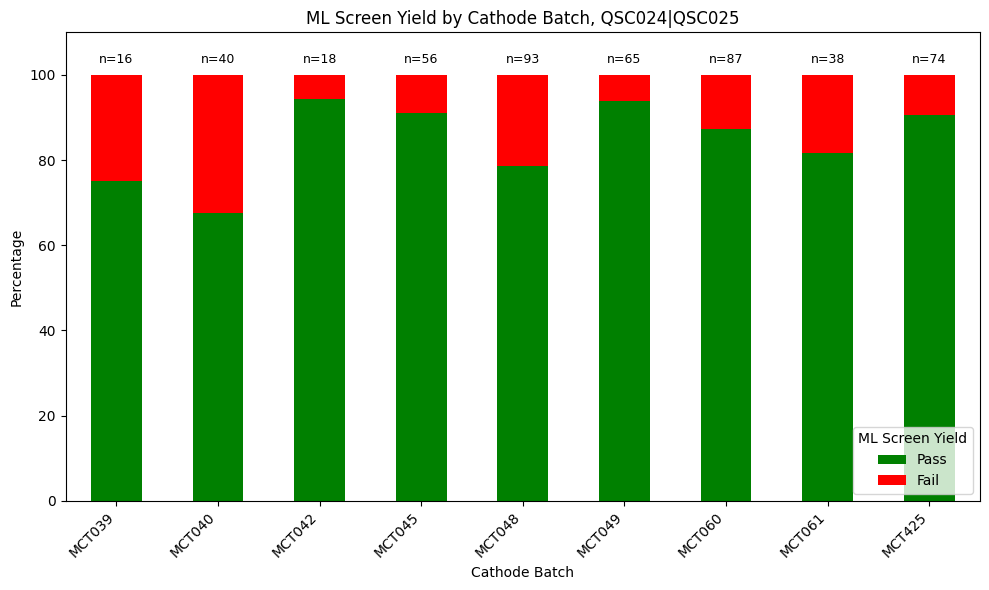

In [199]:
#Plot screen yield by cathode batch

#Remove sub-optimal cells (PS01 cells)
df_Parameters = df_Parameters[~df_Parameters['MultilayerID'].str.contains("PS01", na=False)]

# Count Pass/Fail per Cathode Batch
counts = df_Parameters.groupby(['Cathode Batch', 'ML Screen Yield']).size().unstack(fill_value=0)

# Reorder so 'Pass' is plotted first (bottom), then 'Fail' on top
counts = counts[['Pass', 'Fail']]

# Convert to percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot with red for Pass and green for Fail (in desired order)
ax = percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red'])

# Add total sample count on top of each bar
total_counts = counts.sum(axis=1)
for i, total in enumerate(total_counts):
    ax.text(i, 102, f'n={total}', ha='center', va='bottom', fontsize=9)

# Aesthetics
plt.title(f'ML Screen Yield by Cathode Batch, {search}')
plt.ylabel('Percentage')
plt.xlabel('Cathode Batch')
plt.legend(title='ML Screen Yield', loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)  # Add headroom for the labels
plt.tight_layout()


plt.show()


In [196]:
#Create dataframe for screen yield by cathode batch

#"PU_id", "PU_expt", "cathode_dry_mass", "thickness_avg_um"

CathodeAve = CathodeMetrics.groupby("PU_expt")[["cathode_dry_mass", "thickness_avg_um"]].mean().reset_index()

# Merge and drop 'PU_expt'
CathodeAve = (
    percentages
    .reset_index()
    .merge(CathodeAve, left_on='Cathode Batch', right_on='PU_expt', how='left')
    .drop(columns='PU_expt')
)

df_AllCellParameters = pd.merge(
    CellsInML,
    dfc_consolidated,
    left_on='Cell ID',  # Column in 
    right_on='Cell ID',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)


df_AllCellParameters = pd.merge(
    df_AllCellParameters,
    danc,
    left_on='Cell ID',  # Column in 
    right_on='US_ID',    # Column in 'MLLastTrackCycle'
    how='left'               # Use 'left' join to keep all rows from 
)


# Define the columns to average
cols_to_average = [
    'center_normalized_0_5mm_eroded_rect_outside_median_us',
    'median_contour_catholyte_pct_us',
    'MedDischargeASR_1C',
    'DischargeCapacity_Co3'
]

# Group by 'PU_expt' and calculate the mean of the selected columns
CellAve_Cathode = (
    df_AllCellParameters
    .groupby('PU_expt')[cols_to_average]
    .mean()
    .reset_index()
)

CathodeBatch = CathodeAve.merge(
    CellAve_Cathode,
    left_on='Cathode Batch',
    right_on='PU_expt',
    how='left'
)
CathodeBatch = CathodeBatch.drop(columns='PU_expt')



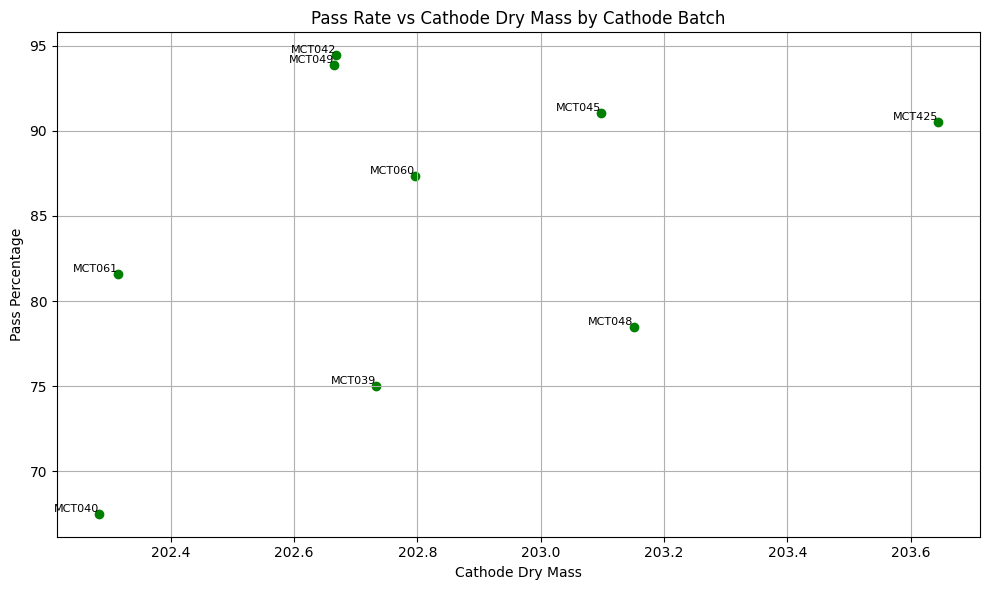

In [197]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(CathodeAve['thickness_avg_um'], CathodeAve['Pass'], color='green')

# Add text labels for each point
for i, label in enumerate(CathodeAve['Cathode Batch']):
    plt.text(CathodeAve['thickness_avg_um'][i], CathodeAve['Pass'][i], label, fontsize=8, ha='right', va='bottom')

# Axis labels and title
plt.xlabel('Cathode Dry Mass')
plt.ylabel('Pass Percentage')
plt.title('Pass Rate vs Cathode Dry Mass by Cathode Batch')
plt.grid(True)
plt.tight_layout()

plt.show()

